In [152]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\jup_lab\movies_2004_2023_cleaned.csv')

### Low budget

In [3]:
genres = ['action','adventure','animated','biographical','black','buddy','comedy',
 'comedy-drama','crime','drama','epic','fantasy','fiction','historical','horror','musical',
 'psychological','romantic','science','sports','superhero','supernatural','thriller','war']

In [4]:
budget_group = df['Budget group']

<Axes: >

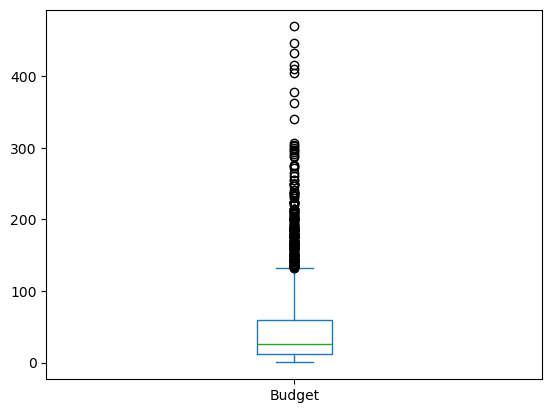

In [5]:
df['Budget'].plot.box()

I'll delete the movies with a too high profit perc. Their success is amazing and hard to replicate.

In [6]:
def get_limits(df):
    print('llimit', str(df.quantile(0.25) - 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('ulimit', str(df.quantile(0.75) + 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme llimit', str(df.quantile(0.25) - 3*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme ulimit', str(df.quantile(0.75) + 3*(df.quantile(0.75) - df.quantile(0.25))))

#### Handling the outliers of Profit perc in low df

In [7]:
get_limits(df.loc[budget_group == 'low', 'Profit perc'])

llimit -639.947915
ulimit 937.468749
Extreme llimit -1231.479164
Extreme ulimit 1528.999998


In [8]:
(df.loc[budget_group == 'low', 'Profit perc'] > 938).sum()

103

In [9]:
low_df = df.loc[(budget_group == 'low') & (df['Profit perc'] < 938)]
low_df.shape

(1104, 33)

In [10]:
def profit_genre(df, genres, col):
    for i in genres:
        if df[i] == 1:
            df[i] = df[col]
    return df

#### I grab the genres that have at least 15 occurrences

In [11]:
low_df[genres].sum(axis=0)

action            72.0
adventure         17.0
animated          12.0
biographical      62.0
black             41.0
buddy             13.0
comedy           256.0
comedy-drama     148.0
crime             63.0
drama            320.0
epic               9.0
fantasy           21.0
fiction           41.0
historical        15.0
horror           139.0
musical           19.0
psychological     53.0
romantic         134.0
science           43.0
sports            24.0
superhero          7.0
supernatural      52.0
thriller         132.0
war               18.0
dtype: float64

# Start analysis

In [12]:
low_genres = low_df[genres].sum(axis=0).loc[low_df[genres].sum(axis=0) > 15].index.tolist()
print(low_genres)

['action', 'adventure', 'biographical', 'black', 'comedy', 'comedy-drama', 'crime', 'drama', 'fantasy', 'fiction', 'horror', 'musical', 'psychological', 'romantic', 'science', 'sports', 'supernatural', 'thriller', 'war']


In [16]:
low_df_profit_perc = low_df[low_genres+ ['Profit perc']].apply(profit_genre, genres=low_genres,
                                     col='Profit perc', axis=1)

low_df_profit_perc[low_df_profit_perc == 0] = np.nan

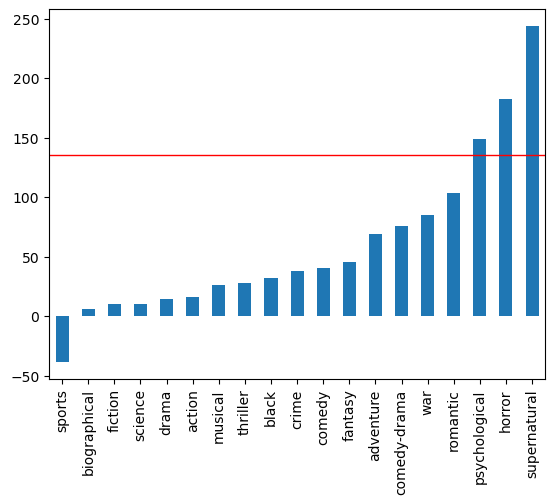

In [108]:
ax = low_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().plot.bar()
ax.hlines(y=low_df_profit_perc['Profit perc'].mean(),
          xmin=-1, xmax=70,
          linewidth=1, color='r');

As we can see some genres have a very different mean from the mean of the whole group. Yet, it's too early to speak. We have to make sure that this is not something produced by chance alone.

In [121]:
pd.set_option('display.float_format',  '{:.4f}'.format)

from scipy.stats import pearsonr

pearsonr_df_stat= []
pearsonr_df_pv= []
pearsonr_id = []

for genre in low_genres:
    values = pearsonr(low_df[genre], low_df['Profit perc'])
    pearsonr_df_stat.append(values[0])
    pearsonr_df_pv.append(values[1])
    pearsonr_id.append(genre)


pearsonr_df = pd.DataFrame(index=pearsonr_id, data={'Correlation coef.':pearsonr_df_stat,
            'P-value':pearsonr_df_pv}).sort_values('P-value')
pearsonr_df

,Correlation coef.,P-value
supernatural,0.1586,0.0000
horror,0.1564,0.0000
psychological,0.0767,0.0108
drama,-0.0702,0.0196
sports,-0.0664,0.0275
biographical,-0.0649,0.0312
action,-0.0513,0.0883
musical,-0.0432,0.1512
romantic,0.0428,0.1551
thriller,-0.0342,0.2563


The only genres we can trust are the ones with a P-value < 0.05

In [122]:
pearsonr_df[pearsonr_df['P-value'] < 0.05]

,Correlation coef.,P-value
supernatural,0.1586,0.0000
horror,0.1564,0.0000
psychological,0.0767,0.0108
drama,-0.0702,0.0196
sports,-0.0664,0.0275
biographical,-0.0649,0.0312


In [124]:
low_genres_trust = pearsonr_df[pearsonr_df['P-value'] < 0.05].index.tolist()

I take that a step further. I wanna be more confident that these genres do indeed influece that Profit %... and it's not by chance.

So I use bootstrapping and confidence intervals.

In [130]:
from scipy.stats import bootstrap

conf_df_id = []
conf_df_low = []
conf_df_high = []

for genre in ['Profit perc'] + low_genres_trust:
    df_to_test = (low_df_profit_perc[genre].dropna(),)
    bootstrap_ci = bootstrap(df_to_test,
                            np.mean,
                            n_resamples=1999,
                            confidence_level=0.95,
                            random_state=1)

    conf_df_id.append(genre)
    conf_df_high.append(bootstrap_ci.confidence_interval[1])
    conf_df_low.append(bootstrap_ci.confidence_interval[0])


conf_df = pd.DataFrame(index=conf_df_id, data={'Low band':conf_df_low,
            'High band':conf_df_high})
conf_df

,Low band,High band
Profit perc,122.4053,150.7354
supernatural,241.0351,393.8443
horror,191.7714,287.9736
psychological,152.1174,302.0253
drama,83.9947,134.7785
sports,-19.1220,121.9025
biographical,28.8718,126.2642


These are the genres that don't overlap at 95% conficende level. We can trust that these genres do actually influence the profit % of a low budget movie.

In [149]:
mask1 = conf_df.loc[:,'Low band'] > conf_df.loc['Profit perc', 'High band']
mask2 = conf_df.loc[:,'High band'] < conf_df.loc['Profit perc', 'Low band']

low_genres_trust = conf_df[(mask1 | mask2)].index.tolist()
conf_df[(mask1 | mask2)]


,Low band,High band
supernatural,241.0351,393.8443
horror,191.7714,287.9736
psychological,152.1174,302.0253
sports,-19.1220,121.9025


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: >

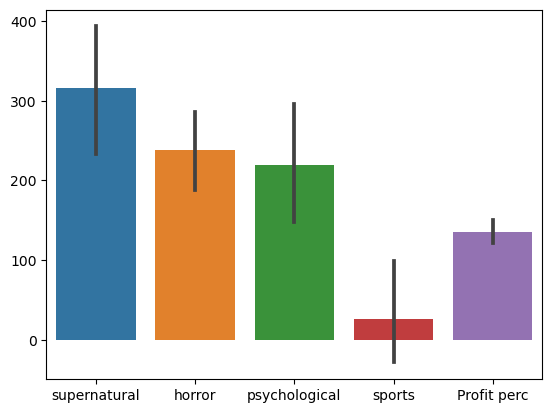

In [160]:
sns.barplot(data=low_df_profit_perc[low_genres_trust + ['Profit perc']], estimator='mean',
            errorbar='ci')